In [22]:
import pandas as pd
import csv
import numpy as np



from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,StratifiedKFold

from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import GradientBoosting
from sklearn.tree import DecisionTreeClassifier




from collections import Counter
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,recall_score,precision_score,auc,f1_score
import matplotlib.pylab as plt
import seaborn as sns

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
nominal_cols=['Auction', 'Make','SubModel','Color', 'Transmission', 'Nationality', 'Size',
       'TopThreeAmericanName', 'VNST', 'WheelTypeID','Trim','IsOnlineSale','PurchDate']

num_cols=['VehicleAge','VehOdo','MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost','WarrantyCost']

global df


def preprocessing(data):
    
    global df
    
    df=data
    df= df.drop(["RefId"],axis=1)
    
    
    return df

# def split_training_set(df):
    
#     train_x,test_x,train_y,test_y=split_train_test()
#     return train_x,test_x,train_y,test_y

def fill_missing_values(df):
    
    
        
    for col in nominal_cols:
        mode=df[col].mode()[0]
        print('filling',col,'with',mode)
        df[col].fillna(value=mode,inplace=True)
        
    for col in num_cols:
        mean=df[col].mean()
        print('filling',col,'with',mean)
        df[col].fillna(value=mean,inplace=True)
    
    df["SubModel"]=df["SubModel"].astype(str).apply(change_submodel)
    df["Size"]=df["Size"].astype(str).apply(change_size)
    df.loc[df["Transmission"]=="Manual","Transmission"]="MANUAL"   
    
    print(df.SubModel.value_counts())
    return df



def change_size (size):
        if "MEDIUM" in size or size in ["SPORTS", "VAN", 'CROSSOVER']:
            return "M"
        if "LARGE" in size:
            return "L"
        if "SMALL" in size or size in ['COMPACT']:
            return "S"
        return "OTHER"


def change_submodel(submodel):
    
    
    if "4D" in submodel or "SEDAN" in submodel or "PASSENGER" in submodel:
                return "4D"
    if "2D" in submodel or "COUPE" in submodel:
                return "2D"
    if "CAB" in submodel:
                return "CAB"
    
    return "OTHER" 


def feature_enginerring(df):
    df.PurchDate=pd.to_datetime(df.PurchDate,format=r'%m/%d/%Y').astype(np.int64)//10**15
    df=df.drop(["VehYear"],axis=1)
#     df=df.drop(["PurchDate"],axis=1)
    df=df.drop(["Model"],axis=1)
#     df['Engine']=df.SubModel.str.extract('\s+(\d+.\d+)L',expand=True)
#     print(df.Engine)
#     df=df.drop(["SubModel"],axis=1)
    df=df.drop(["WheelType"],axis=1)
    df=df.drop(["PRIMEUNIT"],axis=1)
    df=df.drop(["AUCGUART"],axis=1)
    df=df.drop(["VNZIP1"],axis=1)
    df=df.drop(["BYRNO"],axis=1)
    
#     df=data_merge_price_avg(df)
    
    return df
    
def data_merge_price_avg(df):
    
    auction_avg=['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
    df["avg_price"]=sum(df[ave] for ave in auction_avg)/len(auction_avg)
    df=df.drop(auction_avg,axis=1)
    
    return df

def convert_nominal_cols(df):
    
#     for col in nominal_cols:
#         listofitem=list(df[col].unique())
#         df[col]=df[col].map(lambda x: listofitem.index(x))
        
    df=pd.get_dummies(df,columns=nominal_cols)    
#     print (df.select_dtypes(include=["object"]).columns.values)
    return df

    
def filter_data(train_data,y_train, ratio=0.14): #undersampling
    y_train_zero=y_train[y_train==0]
    
    train_dataframe_zero=train_data[y_train==0]
#     print(train_dataframe_zero.loc[2])
    
    
    y_train_one=y_train[y_train==1]
    train_dataframe_one=train_data[y_train==1]
    
    idx=np.random.randint(len(y_train_zero),size=int(ratio*len(y_train_zero)))
    y_train_zero=y_train_zero[idx]
    
    train_dataframe_zero=train_dataframe_zero.iloc[idx,:]
#     print(len(y_train_zero))
#     print(len(y_train_one))
    saved_cols=train_dataframe_zero.columns
    train_dataframe_new=np.concatenate([train_dataframe_zero,train_dataframe_one])
    y_train_new=np.concatenate([y_train_zero,y_train_one])
    
    train_x,val_x,train_y,val_y=train_test_split(train_dataframe_new,y_train_new,
                                                test_size=0.3,random_state=1234)
    train_x=pd.DataFrame(train_x,columns=saved_cols)
    val_x=pd.DataFrame(val_x,columns=saved_cols)
    
    
    return train_x,val_x,train_y,val_y,saved_cols


    


def normlize_data(train_data):
    new_num_cols=['avg_price','VehicleAge','VehOdo','VehBCost','WarrantyCost']
    for col in new_num_cols:
        train_data[col]=(train_data[col]-np.mean(train_data[col],axis=0))/(np.std(train_data[col],axis=0))

    return train_data

def suffle_data(train_data,y_train):
    idx=np.random.randint(len(y_train),size=int(len(y_train)))
    y_train=y_train[idx]
    train_data=train_data[idx,:]
    return train_data,y_train

In [24]:
class pipeline():
    def __init__(self, data_file):
        
        self.raw_data=pd.read_csv(data_file,header=0,encoding="cp949")
        self.y_train=np.array(self.raw_data["IsBadBuy"])
        self.raw_data.drop("IsBadBuy",axis=1,inplace=True)
        
        self.preprocess_data()
        
    def preprocess_data(self):
        self.transformed_data=feature_enginerring(self.raw_data)
        self.transformed_data=fill_missing_values(self.transformed_data)
        self.transformed_data=convert_nominal_cols(self.transformed_data)
        self.transformed_data=data_merge_price_avg(self.transformed_data)
        
        print("processing data")
        self.transformed_data=preprocessing(self.transformed_data)
        

In [25]:
def image_graph(train_x,train_y,model):
    pred_prob=model.predict_proba(train_x)[:,1]
    pred=model.predict(train_x)
   
    fpr,tpr,thresholds=roc_curve(train_y,pred_prob)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()
    print("accuracy: %.4f"%accuracy_score(train_y,pred))
    print("precision: %4f"%precision_score(train_y,pred))
    print("recall_rate: %4f"%recall_score(train_y,pred))
    print("f1_score: %4f"%f1_score(train_y,pred))
    print("AUC: %4f"%auc(fpr,tpr))

In [26]:
def logistic(train_x,train_y,val_x,val_y):
    kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1231)
    logit=LogisticRegression()
    Cs=[0.01,0.1,0.5]
    penaltys=["l1","l2"]
    class_weights=["balanced",None]
#     scores=cross_val_score(logit,train_x,train_y,cv=kfold)
#     print("average score is",sum(scores)/10)
    param_grid={'C':Cs,"penalty":penaltys,"class_weight":class_weights}
    logit_clf=GridSearchCV(logit,param_grid,cv=kfold,n_jobs= -1,scoring='f1')
    
    logit_clf.fit(train_x,train_y)
    pred=logit_clf.predict(val_x)
    
    print (metrics.classification_report(val_y, pred)) 
    print ("정확도: %.2f" %metrics.accuracy_score(val_y, pred))
    return logit_clf
    

In [27]:
def support_vector_machine(train_x,train_y,val_x,val_y):
    
    
    svc=svm.SVC(C=1.0,kernel="linear")
    Cs = [0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels=["rbf","linear"]
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel': kernels}
    grid_search = GridSearchCV(svc,param_grid, cv=5,n_jobs=-1,verbose=True,scoring="auc")
#     ramdom_search=RandomizedSearchCV()
    grid_search.fit(train_x, train_y)
#     svc=svm.SVC(C=grid_search.best_estimator_.C,
#                 kernel=grid_search.best_estimator_.kernel,
#                 gamma=grid_search.best_estimator_.gamma,
#                max_iter=100)
#     svc.fit(train_x,train_y)
    pred=grid_search.predict(val_x)
    
#     logistic=LogisticRegression(C=logistic_clf.best_estimator_.C,penalty=logistic_clf.best_estimator_.penalty,class_weight=logistic_clf.best_estimator_.class_weight,
#                                 max_iter=100, verbose=1)
    print (metrics.classification_report(val_y, pred)) 
    print ("정확도: %.2f" %metrics.accuracy_score(val_y, pred))
    return grid_search

In [28]:
def random_forest(train_x,train_y,val_x,val_y):
    forest=RandomForestClassifier(n_estimators=250,
                                 random_state=1231,bootstrap="True")
    kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1231)
#     forest_clf=GridSearchCV(estimator=forest, param_grid=dict(n_estimators=[100],
#                                                              warm_start=[True, False]), cv=10, n_jobs=-1)
    scoring="roc_auc"
    results=cross_val_score(forest,train_x,train_y,cv=kfold,scoring=scoring,n_jobs=-1)
    print("train_validation",results)
    forest.fit(train_x,train_y)
#     forest=RandomForestClassifier(n_estimators=forest_clf.best_estimator_.n_estimators,
#                                   cirterion="entropy",
#                                   warm_start=forest_clf.best_estimator_.warm_start)
#     forest.fit(train_x,train_y)
    pred=forest.predict(val_x)
#     pred=forest.predict(val_x)
    print (metrics.classification_report(val_y, pred)) 
    print ("정확도: %.2f" %metrics.accuracy_score(val_y, pred))
    return forest
    

In [29]:
def xgb_boost(train_x,train_y,val_x,val_y):
    xgb_model=xgboost.XGBClassifier(n_estimators=100,max_depth=5)
    param_grid={"objective":["binary:logistic"],
                "learning_rate":[0.01,0.02,0.05,0.10,0.15,0.2],
                "max_depth":[5,6,7],
                "min_child_weight":[1],
                "seed":[1000],
               "n_estimators":[100,200,300,500,1000],
               }
    xgb_clf=GridSearchCV(xgb_model,param_grid,n_jobs=-1,cv=10)
    xgb_clf.fit(train_x,train_y)
    pred=xgb_clf.predict(val_x)
    print (metrics.classification_report(val_y, pred)) 
    print ("정확도: %.2f" %metrics.accuracy_score(val_y, pred))
    return xgb_clf
    

In [30]:
def over_sampling(train_data):

    train_x,val_x,train_y,val_y=train_test_split(train_data.transformed_data,train_data.y_train,
                                                test_size=0.2,random_state=1234)
#     print(train_x)
#     print(val_x)
    sm=SMOTEENN(random_state=1231)
    train_x_over,train_y_over=sm.fit_sample(train_x,train_y)
    train_x_over=pd.DataFrame(train_x_over)
    train_x_over.columns=val_x.columns
#     print(train_x_over)
    return train_x_over,val_x,train_y_over,val_y

In [31]:
def score_model(model):
    return cv.cross_val_score(model, train_x_over, train_y_over, cv=skf, scoring='roc_auc')

In [37]:
def pca_reduce_feature(data):
    model = PCA(n_components=80)
    pca_features = model.fit_transform(data)
    return pca_features

In [33]:
train_data="./training.csv"
train_data=pipeline(train_data)

filling Auction with MANHEIM
filling Make with CHEVROLET
filling SubModel with 4D SEDAN
filling Color with SILVER
filling Transmission with AUTO
filling Nationality with AMERICAN
filling Size with MEDIUM
filling TopThreeAmericanName with GM
filling VNST with TX
filling WheelTypeID with 1.0
filling Trim with Bas
filling IsOnlineSale with 0
filling PurchDate with 1291
filling VehicleAge with 4.176643875971116
filling VehOdo with 71499.99591685736
filling MMRAcquisitionAuctionAveragePrice with 6128.909216747756
filling MMRAcquisitionAuctionCleanPrice with 7373.636030973755
filling MMRAcquisitionRetailAveragePrice with 8497.034331528816
filling MMRAcquisitonRetailCleanPrice with 9850.928239566916
filling MMRCurrentAuctionAveragePrice with 6132.081287499312
filling MMRCurrentAuctionCleanPrice with 7390.681826938955
filling MMRCurrentRetailAveragePrice with 8775.723330764573
filling MMRCurrentRetailCleanPrice with 10145.385314030935
filling VehBCost with 6730.934326212953
filling WarrantyCos

In [34]:
train_x_down,val_x_down,train_y_down,val_y_down,header=filter_data(train_data.transformed_data,train_data.y_train)
train_x_over,val_x_over,train_y_over,val_y_over=over_sampling(train_data)

In [38]:
train_x_down=normlize_data(train_x_down)
val_x_down=normlize_data(val_x_down)
train_x_over=normlize_data(train_x_over)
val_x_over=normlize_data(val_x_over)

train_x_down_pca=pca_reduce_feature(train_x_down)
val_x_down_pca=pca_reduce_feature(val_x_down)
train_x_over_pca=pca_reduce_feature(train_x_over)
val_x_over_pca=pca_reduce_feature(val_x_over)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1231)

---
# LOGISTIC REGRESSION


In [29]:
logistic_clf_down=logistic(train_x_down,train_y_down,val_x_down,val_y_down)

             precision    recall  f1-score   support

          0       0.65      0.65      0.65      2241
          1       0.65      0.65      0.65      2243

avg / total       0.65      0.65      0.65      4484

정확도: 0.65


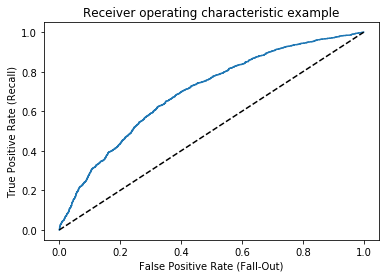

accuracy: 0.6494
precision: 0.648649
recall_rate: 0.652697
f1_score: 0.650667
AUC: 0.697163


In [30]:
image_graph(val_x_down,val_y_down.ravel(),logistic_clf_down)

In [31]:
logistic_clf1=logistic(train_x_over,train_y_over,val_x_over,val_y_over)

             precision    recall  f1-score   support

          0       0.94      0.50      0.65     12803
          1       0.18      0.77      0.29      1794

avg / total       0.84      0.53      0.61     14597

정확도: 0.53


----
# SUPPORT VECTOR MACHINE

In [ ]:
svm_down=support_vector_machine(train_x_down,train_y_down,val_x_down,val_y_down)

In [ ]:
svm_over=support_vector_machine(train_x_over_pca,train_y_over,val_x_over_pca,val_y_over)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 374.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 1643.3min


In [ ]:
image_graph(val_x_over_pca,val_y_over,svm_over)

-----
# RANDOM_FOREST

In [56]:
rand_down=RandomForestClassifier(n_estimators=1000,criterion="entropy",
                                bootstrap=False)
rand_down.fit(train_x_down,train_y_down)
pred_rand_down=rand_down.predict(val_x_down)
print(metrics.classification_report(val_y_down,pred_rand_down))
print(metrics.accuracy_score(val_y_down,pred_rand_down))

             precision    recall  f1-score   support

          0       0.67      0.64      0.66      2687
          1       0.66      0.68      0.67      2694

avg / total       0.66      0.66      0.66      5381

0.6623304218546738


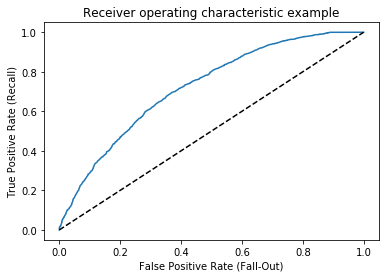

accuracy: 0.6623
precision: 0.657112
recall_rate: 0.680772
f1_score: 0.668733
AUC: 0.721529


In [57]:
image_graph(val_x_down,val_y_down,rand_down)

In [49]:
rand_over=RandomForestClassifier(n_estimators=1000,criterion="entropy",
                                bootstrap=False)
rand_over.fit(train_x_over,train_y_over)
pred_rand_over=rand_over.predict(val_x_over)
print(metrics.classification_report(val_y_over,pred_rand_over))
print(metrics.accuracy_score(val_y_over,pred_rand_over))

             precision    recall  f1-score   support

          0       0.90      0.92      0.91     12803
          1       0.29      0.23      0.26      1794

avg / total       0.82      0.84      0.83     14597

0.8372268274302939


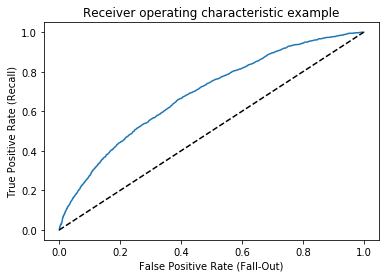

accuracy: 0.8372
precision: 0.293909
recall_rate: 0.231327
f1_score: 0.258890
AUC: 0.686947


In [52]:
image_graph(val_x_over,val_y_over,rand_over)

----
# ADABOOST

In [70]:
from sklearn.ensemble import AdaBoostClassifier

ada_model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),n_estimators=100,random_state=12)
ada_model.fit(train_x_over,train_y_over)
pred2=ada_model.predict(val_x_over)
print(metrics.classification_report(val_y_over,pred2))
print(metrics.accuracy_score(val_y_over,pred2))

             precision    recall  f1-score   support

          0       0.90      0.58      0.70     12803
          1       0.15      0.54      0.24      1794

avg / total       0.81      0.57      0.65     14597

0.571555799136809


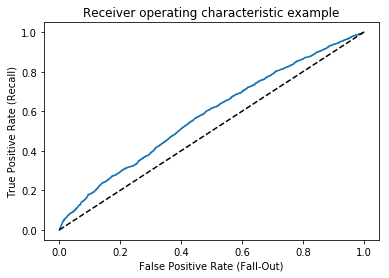

accuracy: 0.5716
precision: 0.150689
recall_rate: 0.536232
f1_score: 0.235265
AUC: 0.579155


In [71]:
image_graph(val_x_over,val_y_over,ada_model)

In [525]:
ada_down= AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100, random_state=100)
ada_down.fit(train_x_down,train_y_down)
ada_down_pred=ada_down.predict(val_x_down)
print(metrics.classification_report(val_y_down,ada_down_pred))
print(metrics.accuracy_score(val_y_down,ada_down_pred))

             precision    recall  f1-score   support

          0       0.61      0.61      0.61      2241
          1       0.61      0.61      0.61      2243

avg / total       0.61      0.61      0.61      4484

0.6090544157002676


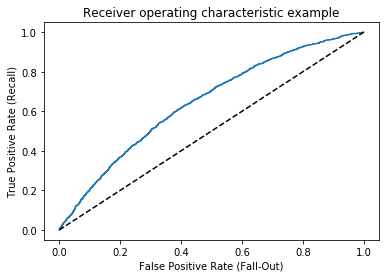

accuracy: 0.6091
precision: 0.609964
recall_rate: 0.605885
f1_score: 0.607918
AUC: 0.645872


In [526]:
image_graph(val_x_down,val_y_down,ada_down)

----
# XGBOOST

In [58]:
xgb_model_down=xgboost.XGBClassifier(n_estimators=100,
                                     max_depth=5,
                                     objective="binary:logistic",
                                     cv=10,
                                     booster='gbtree',
                                     bootstrap=False,
                                     learning_rate=0.1,
                                     subsample=0.4,
                                     eval_metric="auc"
                                    )
xgb_model_down.fit(train_x_down,train_y_down)
pred=xgb_model_down.predict(val_x_down)
print(metrics.classification_report(val_y_down,pred))
print(metrics.accuracy_score(val_y_down,pred))

             precision    recall  f1-score   support

          0       0.66      0.64      0.65      2687
          1       0.65      0.67      0.66      2694

avg / total       0.65      0.65      0.65      5381

0.6521092733692622


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


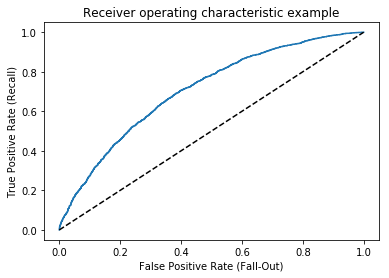

accuracy: 0.6521
precision: 0.647948
recall_rate: 0.668151
f1_score: 0.657895
AUC: 0.705947


In [62]:
image_graph(val_x_down,val_y_down,xgb_model_down)

In [ ]:
# kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1231)

In [66]:
xgb_model2=xgboost.XGBClassifier(n_estimators=100,
                                 max_depth=5,
                                 objective="binary:logistic",
                                 cv=10,
                                 booster='gbtree',
                                 bootstrap=False,
                                 learning_rate=0.1,
                                 eval_metric='auc',
                                 subsample=0.4)
xgb_model2.fit(train_x_over,train_y_over)
pred=xgb_model2.predict(val_x_over)
print(metrics.classification_report(val_y_over,pred))
print(metrics.accuracy_score(val_y_over,pred))

             precision    recall  f1-score   support

          0       0.91      0.66      0.77     12803
          1       0.18      0.54      0.27      1794

avg / total       0.82      0.65      0.71     14597

0.6455436048503117


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


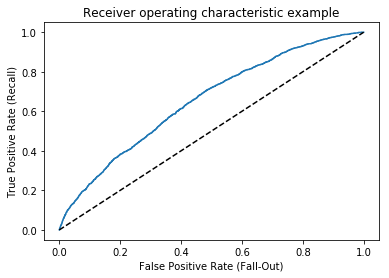

accuracy: 0.6455
precision: 0.182927
recall_rate: 0.543478
f1_score: 0.273723
AUC: 0.653433


In [67]:
image_graph(val_x_over,val_y_over,xgb_model2)

____

In [ ]:
skf=cv.StratifiedKFolf(y,n_folds=10,shuffle=True)

def score_model(model,x,y):
    return cv.cross_val_score(model,x,y,cv=skf,scoring="roc_auc")


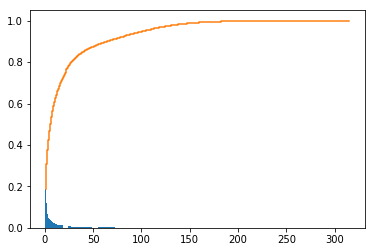

In [489]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA


pca = PCA().fit(train_x_down)
var = pca.explained_variance_
cmap = sns.color_palette()
plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()


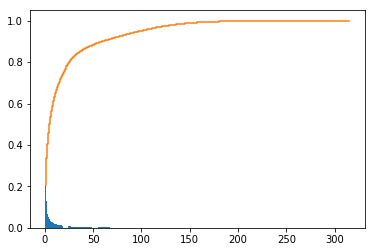

In [490]:
pca = PCA().fit(train_x_over)
var = pca.explained_variance_
cmap = sns.color_palette()
plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()


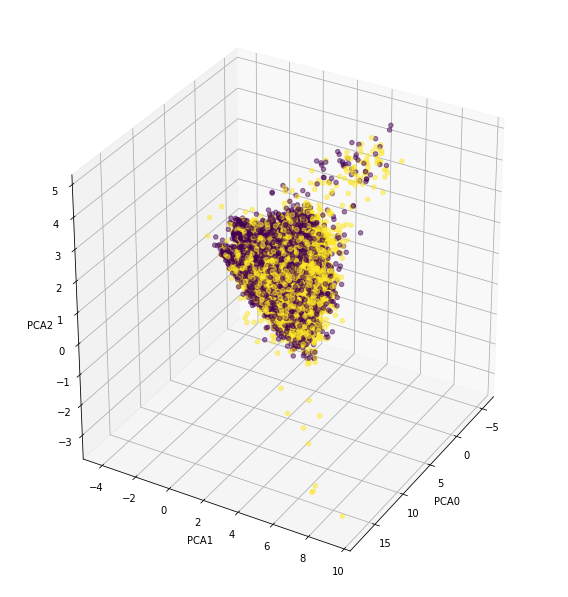

In [103]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model = PCA(n_components=50)
pca_features = model.fit_transform(train_x_down)

fig = plt.figure( figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=30)
ax.scatter(pca_features[:,0],pca_features[:,1],pca_features[:,2],c=train_y_down,alpha=0.5)
ax.set_xlabel('PCA0')
ax.set_ylabel('PCA1')
ax.set_zlabel('PCA2')
plt.show()

In [39]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [73]:
clf1=RandomForestClassifier(random_state=0)
clf2=AdaBoostClassifier(random_state=0)
clf3=xgboost.XGBClassifier(random_state=0)
clf4=LogisticRegression()

eclf2 = VotingClassifier(estimators=[
         ('rand', clf1), ('ada', clf2), ('xgb', clf3),('logit',clf4)],
         voting='soft')
eclf2 = eclf2.fit(train_x_over, train_y_over)
pred_elf=eclf2.predict(val_x_over)
print(metrics.classification_report(val_y_over,pred_elf))
print(metrics.accuracy_score(val_y_over,pred_elf))

             precision    recall  f1-score   support

          0       0.92      0.74      0.82     12803
          1       0.22      0.51      0.31      1794

avg / total       0.83      0.71      0.76     14597

0.7145988901829143


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


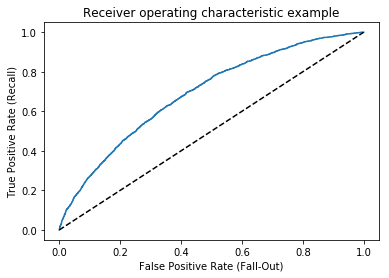

accuracy: 0.7146
precision: 0.218022
recall_rate: 0.511148
f1_score: 0.305667
AUC: 0.690565


In [74]:
image_graph(val_x_over,val_y_over,eclf2)

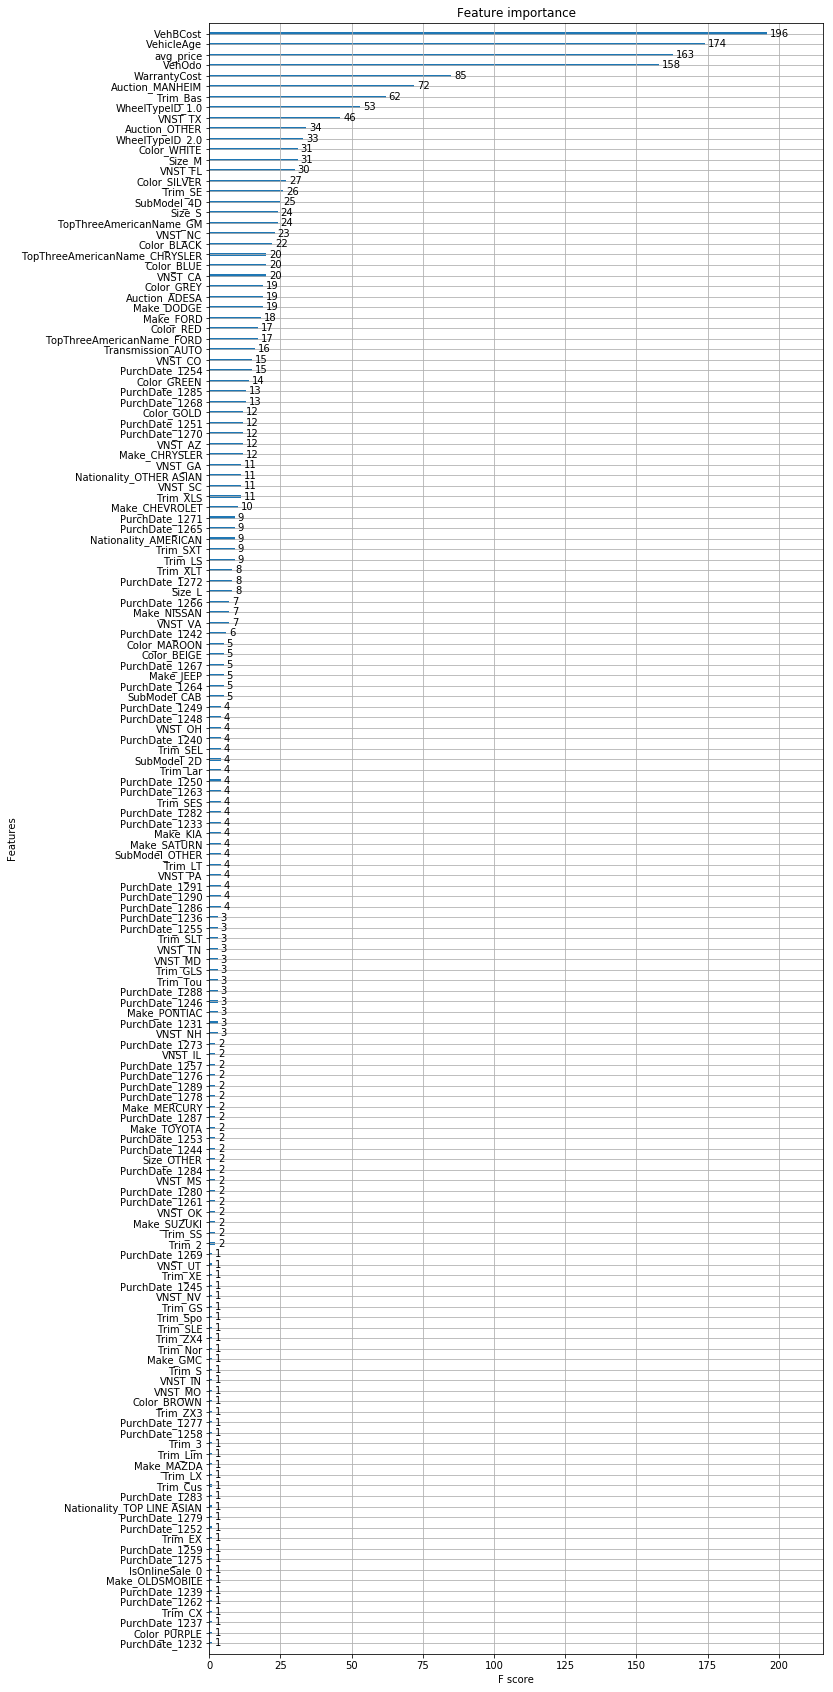

In [93]:
figsize=(11,30)
fig, ax = plt.subplots(1,1,figsize=figsize)
xgboost.plot_importance(xgb_model2,ax=ax,importance_type="weight")
plt.show()